### Preparation:
### before we start, we need to get kan library, run:
```
git clone https://github.com/KindXiaoming/pykan.git
cd pykan
pip install -e .
```
#### That implements the Kolmogorov-Arnold Network (KAN) architecture. 

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


checkpoint directory created: ./model
saving model version 0.0


/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/42], Loss: 2.7143, Val F1: 0.0799


/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/42], Loss: 2.6707, Val F1: 0.1862


/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/42], Loss: 2.6269, Val F1: 0.2612


/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/42], Loss: 2.5791, Val F1: 0.3187
Epoch [5/42], Loss: 2.5248, Val F1: 0.3595
Epoch [6/42], Loss: 2.4630, Val F1: 0.4074
Epoch [7/42], Loss: 2.3933, Val F1: 0.4426
Epoch [8/42], Loss: 2.3152, Val F1: 0.4743
Epoch [9/42], Loss: 2.2279, Val F1: 0.5248
Epoch [10/42], Loss: 2.1308, Val F1: 0.5647
Epoch [11/42], Loss: 2.0242, Val F1: 0.6013
Epoch [12/42], Loss: 1.9094, Val F1: 0.6254
Epoch [13/42], Loss: 1.7896, Val F1: 0.6562
Epoch [14/42], Loss: 1.6685, Val F1: 0.6732
Epoch [15/42], Loss: 1.5485, Val F1: 0.7019
Epoch [16/42], Loss: 1.4307, Val F1: 0.7345
Epoch [17/42], Loss: 1.3164, Val F1: 0.7607
Epoch [18/42], Loss: 1.2080, Val F1: 0.7816
Epoch [19/42], Loss: 1.1081, Val F1: 0.7878
Epoch [20/42], Loss: 1.0180, Val F1: 0.7962
Epoch [21/42], Loss: 0.9365, Val F1: 0.8042
Epoch [22/42], Loss: 0.8628, Val F1: 0.8140
Epoch [23/42], Loss: 0.7974, Val F1: 0.8197
Epoch [24/42], Loss: 0.7392, Val F1: 0.8251
Epoch [25/42], Loss: 0.6873, Val F1: 0.8342
Epoch [26/42], Loss: 0.6418, Val F1: 0

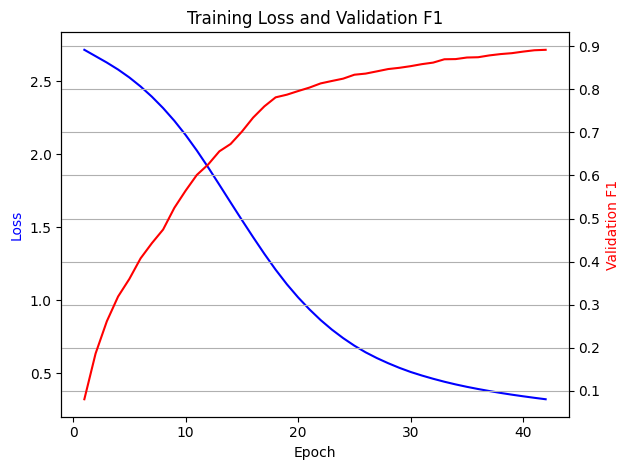

[KAN] Accuracy: 0.8883, Precision: 0.8885, Recall: 0.8883, F1-score: 0.8880


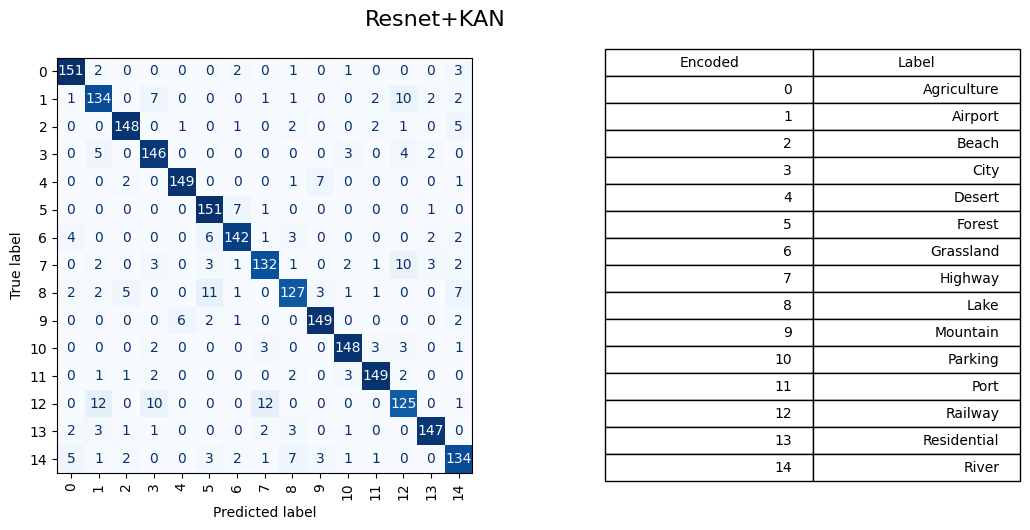

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from kan import KAN
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2


torch.manual_seed(42)    #randomseed
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset_path = "/root/autodl-fs/train_dataset"
test_dataset_path = "/root/autodl-fs/test_dataset"

class AerialSceneDataset(Dataset):   #define data class
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

### transform
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


categories = os.listdir(train_dataset_path)  # get names of folders
num_classes = len(categories)
test_categories = os.listdir(test_dataset_path)
if set(test_categories) != set(categories):
    raise ValueError("Training and testing categories do not match!")  # just in case
category_to_idx = {cat: idx for idx, cat in enumerate(categories)}

label_names = [cat for cat, _ in sorted(category_to_idx.items(), key=lambda x: x[1])]



def load_paths_and_labels(root_path):
    image_paths, labels = [], []
    for category in categories:
        cat_path = os.path.join(root_path, category)
        cat_images = glob.glob(os.path.join(cat_path, "*.jpg"))
        image_paths.extend(cat_images)
        labels.extend([category_to_idx[category]] * len(cat_images))
    return image_paths, labels

train_image_paths, train_labels = load_paths_and_labels(train_dataset_path)
test_image_paths, test_labels = load_paths_and_labels(test_dataset_path)

train_dataset = AerialSceneDataset(train_image_paths, train_labels, transform=transform)
test_dataset = AerialSceneDataset(test_image_paths, test_labels, transform=transform)

##### get validation
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len
real_train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len])


train_loader = DataLoader(real_train_dataset, batch_size=16, shuffle=True) #shuffle the order of the trainset for model’s generalization
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### extract feature!
def extract_features(loader):
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            feats = resnet(images).view(images.size(0), -1)
            features.append(feats.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# modify a ResNet to help us extract feature
resnet = models.resnet18(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet = resnet.to(device)
resnet.eval()

train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

train_features = torch.tensor(train_features, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.long).to(device)
val_features = torch.tensor(val_features, dtype=torch.float32).to(device)
val_labels = torch.tensor(val_labels, dtype=torch.long).to(device)
test_features = torch.tensor(test_features, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.long).to(device)

###KAN !!!!!!!!!                  ResNet18 feature ↓
input_dim, hidden_dim1, hidden_dim2, output_dim = 512, 128, 64, num_classes   #this is 2 times stack KAN. the former only 1 stack layer: KAN[512,64,15] is not good enough.
#         each spline f in KAN will split input domain into 5 intervals ↓    ↓ cubic splines, which means we use 3rd-degree polynomials
kan = KAN(width=[input_dim, hidden_dim1, hidden_dim2, output_dim], grid=5, k=3, seed=42).to(device)



           ###
class EarlyStopping:
    def __init__(self, patience=5, delta=1e-4):
        self.patience = patience                     #at most 5 epoch not up
        self.delta = delta                           #minimum nu of up
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None          #save best model
        self.f1_scores = []                          #record each f1

    def __call__(self, score, model):
        self.f1_scores.append(score)
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            self.best_model_state = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

optimizer = torch.optim.Adam(kan.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping()
train_losses = []




for epoch in range(42):
    kan.train()
    optimizer.zero_grad()
    outputs = kan(train_features)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    kan.eval()
    with torch.no_grad():
        val_outputs = kan(val_features)
        _, val_predicted = torch.max(val_outputs, 1)
        val_f1 = precision_recall_fscore_support(val_labels.cpu().numpy(), val_predicted.cpu().numpy(), average='weighted')[2]

    print(f"Epoch [{epoch+1}/42], Loss: {loss.item():.4f}, Val F1: {val_f1:.4f}")

    del outputs, val_outputs, val_predicted
    torch.cuda.empty_cache()


    early_stopper(val_f1, kan)
    if early_stopper.early_stop:
        print(f"Early stopping at epoch {epoch+1}, Best F1: {early_stopper.best_score:.4f}")
        break

kan.load_state_dict(early_stopper.best_model_state)

# draw train loss & validation F1
fig, ax1 = plt.subplots()
ax1.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='blue')
ax2 = ax1.twinx()
ax2.plot(range(1, len(early_stopper.f1_scores)+1), early_stopper.f1_scores, label='Val F1', color='red')
ax2.set_ylabel('Validation F1', color='red')
plt.title('Training Loss and Validation F1')
fig.tight_layout()
plt.grid(True)
plt.show()

#######evaluation!
kan.eval()
with torch.no_grad():
    outputs = kan(test_features)
    _, predicted = torch.max(outputs, 1)
    predicted_np = predicted.cpu().numpy()
    true_labels_np = test_labels.cpu().numpy()

precision, recall, f1, _ = precision_recall_fscore_support(true_labels_np, predicted_np, average='weighted')
acc = accuracy_score(true_labels_np, predicted_np)
print(f"[KAN] Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

cm = confusion_matrix(true_labels_np, predicted_np)
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

ax0 = plt.subplot(gs[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
disp.plot(cmap='Blues', ax=ax0, xticks_rotation='vertical', colorbar=False)
ax1 = plt.subplot(gs[1])
ax1.axis('off')
table_data = [[i, label] for i, label in enumerate(label_names)]
table = ax1.table(cellText=table_data, colLabels=["Encoded", "Label"], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)


plt.tight_layout()
plt.suptitle("Resnet+KAN", fontsize=16, y=1.05)
plt.show()

